In [29]:
import pandas as pd
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# load data as csv files

In [2]:
dMonday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_combined/monday080124.csv')
dTuesday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_combined/tuesday090124.csv')
dWednesday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_combined/wednesday100124.csv')
dThursday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_combined/Thursday110124.csv')
dFriday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_combined/Friday120124.csv')

/var/folders/z4/0m49679n1xd2nv8l_dt8zz880000gn/T/ipykernel_45950/933017804.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dMonday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_combined/monday080124.csv')
/var/folders/z4/0m49679n1xd2nv8l_dt8zz880000gn/T/ipykernel_45950/933017804.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dTuesday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_combined/tuesday090124.csv')


# filter data to keep only requested data

In [5]:
# filter for devices that comunicate with an cisco router
def filter(data):
    eduroam_ssid = '656475726f616d'

    # The ^ tell the regular expression, that it start with the pattern that follows
    cisco_pattern = '^' + '00:f6:63:'

    df_dpa = data.loc[data['_ws.col.protocol'] == 'EAP']

    # Authentication with all cisco devices
    df_dpa_cisco = df_dpa.loc[df_dpa['wlan.sa'].str.match(cisco_pattern)]

    # Authenticated mac addresses as a list
    dpa_cisco_list = df_dpa_cisco['wlan.da'].unique().tolist()

    # all unique mac addresses with the ssids
    all_sources = data['wlan.sa'].unique().tolist()

    # Combination of mac addresses of the ssids and EPA
    combined_macs = list(set(all_sources + dpa_cisco_list))
    print(f'Number of unqiue mac addresses verfied by cisco: {df_dpa_cisco["wlan.da"].nunique()}')

    # All entries that use the resulting mac addresses
    return data.loc[data['wlan.sa'].isin(combined_macs)]

In [6]:
# use filter method
dFilteredMonday  = filter(dMonday)
dFilteredTuesday  = filter(dTuesday)
dFilteredWednesday  = filter(dWednesday)
dFilteredThursday  = filter(dThursday)
dFilteredFriday  = filter(dFriday)

Number of unqiue mac addresses verfied by cisco: 995
Number of unqiue mac addresses verfied by cisco: 329
Number of unqiue mac addresses verfied by cisco: 1189
Number of unqiue mac addresses verfied by cisco: 757
Number of unqiue mac addresses verfied by cisco: 413


In [10]:
# change time format to readable format and remove NaNs
def changeTimeFormat(data):
    data['frame.time'] = data['frame.time'].str.replace(r':\d+\.\d+', '', regex=True)
    data['frame.time'] = data['frame.time'].str.replace('Mitteleuropäische Zeit', 'CET')
    data['date-time'] = pd.to_datetime(data['frame.time'], format='%b %d, %Y %H:%M %Z', errors='coerce')
    data['hour:minute'] = data['date-time'].dt.strftime('%H:%M')
    data.dropna(subset=['wlan.sa'], inplace = True)
    data['wlan.ssid'].value_counts().sort_index()

    return data

In [11]:
dFilteredMonday  = changeTimeFormat(dMonday)
dFilteredTuesday  = changeTimeFormat(dTuesday)
dFilteredWednesday  = changeTimeFormat(dWednesday)
dFilteredThursday  = changeTimeFormat(dThursday)
dFilteredFriday  = changeTimeFormat(dFriday)

# Create Dataframe first and last seen

In [12]:
dFirstMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='first')
dLastMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='last')
dFirstTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='first')
dLastTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='last')
dFirstWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='first') 
dLastWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='last')
dFirstThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='first')
dLastThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='last')
dFirstFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='first')
dLastFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='last')

# Create Dataframe count of first and last seen add

In [26]:
dCountFirstMonday = pd.DataFrame(dFirstMonday['hour:minute'].value_counts().sort_index())
dCountLastMonday = pd.DataFrame(dLastMonday['hour:minute'].value_counts().sort_index())
dCountFirstTuesday = pd.DataFrame(dFirstTuesday['hour:minute'].value_counts().sort_index())
dCountLastTuesday = pd.DataFrame(dLastTuesday['hour:minute'].value_counts().sort_index())
dCountFirstWednesday = pd.DataFrame(dFirstWednesday['hour:minute'].value_counts().sort_index())
dCountLastWednesday = pd.DataFrame(dLastWednesday['hour:minute'].value_counts().sort_index())
dCountFirstThursday = pd.DataFrame(dFirstThursday['hour:minute'].value_counts().sort_index())
dCountLastThursday = pd.DataFrame(dLastThursday['hour:minute'].value_counts().sort_index())
dCountFirstFriday = pd.DataFrame(dFirstFriday['hour:minute'].value_counts().sort_index())
dCountLastFriday = pd.DataFrame(dLastFriday['hour:minute'].value_counts().sort_index())

# Create Dataframe count of frist and last sean mac add every x min

In [27]:
def resampleToTime(period, data):
    data = pd.DataFrame({'hour:minute':data.index.tolist(),'count': data['count']})
    data['hour:minute'] = pd.to_datetime(data['hour:minute'], format='%H:%M')
    data['hour:minute'].dt.strftime('%H:%M')
    data.set_index('hour:minute',inplace=True)
    
    return data.resample(period + 'T').sum()

In [28]:
d5CountFirstMonday = resampleToTime('5', dCountFirstMonday)
d5CountLastMonday = resampleToTime('5', dCountLastMonday)
d5CountFirstTuesday = resampleToTime('5', dCountFirstTuesday)
d5CountLastTuesday = resampleToTime('5', dCountLastTuesday)
d5CountFirstWednesday = resampleToTime('5', dCountFirstWednesday)
d5CountLastWednesday = resampleToTime('5', dCountLastWednesday)
d5CountFirstThursday = resampleToTime('5', dCountFirstThursday)
d5CountLastThursday = resampleToTime('5', dCountLastThursday)
d5CountFirstFriday = resampleToTime('5', dCountFirstFriday)
d5CountLastFriday = resampleToTime('5', dCountLastFriday)

Text(0.5, 1.0, 'first seen Count / 5 min')

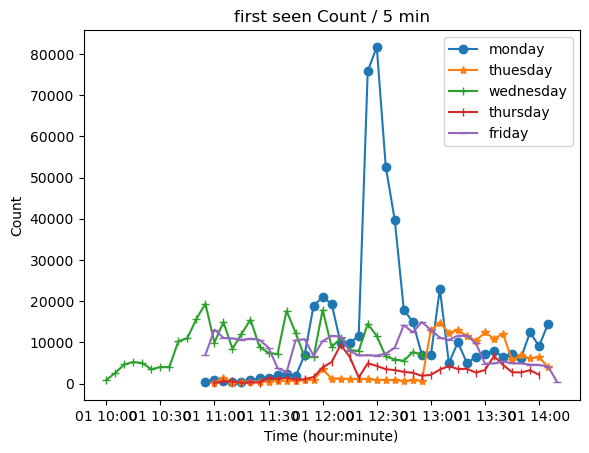

In [42]:
plt.plot(d5CountFirstMonday['count'], marker='o', label='monday')
plt.plot(d5CountFirstTuesday['count'], marker='*', label='thuesday')
plt.plot(d5CountFirstWednesday['count'], marker='+', label='wednesday')
plt.plot(d5CountFirstThursday['count'], marker='|', label='thursday')
plt.plot(d5CountFirstFriday['count'], marker='_', label='friday')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.legend()
plt.title('first seen Count / 5 min')

Text(0.5, 1.0, 'last seen Count / 5 min')

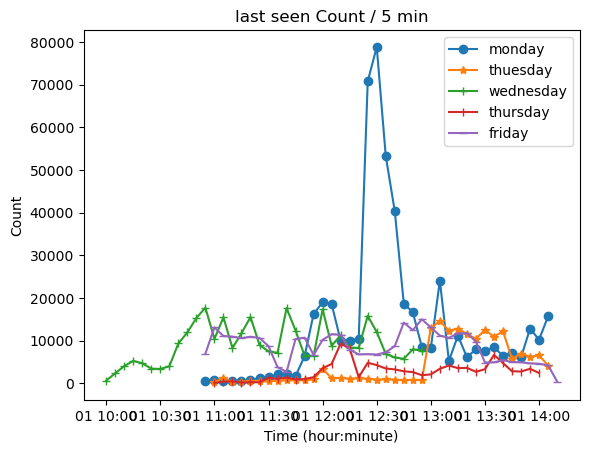

In [43]:
plt.plot(d5CountLastMonday['count'], marker='o', label='monday')
plt.plot(d5CountLastTuesday['count'], marker='*', label='thuesday')
plt.plot(d5CountLastWednesday['count'], marker='+', label='wednesday')
plt.plot(d5CountLastThursday['count'], marker='|', label='thursday')
plt.plot(d5CountLastFriday['count'], marker='_', label='friday')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.legend()
plt.title('last seen Count / 5 min')